In [1]:
from __future__ import print_function
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import random
from optparse import OptionParser
import pandas as pd
import itertools

import bioframe
import akita_utils

from io import StringIO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import h5py

2022-11-07 13:28:01.601065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-11-07 13:28:01.601096: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# list of targets
# /project/fudenber_735/tensorflow_models/akita/v2/data/mm10/targets.txt & /project/fudenber_735/tensorflow_models/akita/v2/data/hg38/targets.txt

In [3]:
filename = "/home1/smaruj/akita_utils/bin/insert_virtual_flanks_experiment/data/seq_11_grid-plotting.h5"

In [4]:
hf = h5py.File(filename, "r")
num_experiments = len(list(hf["flank_bp"]))

In [5]:
for key in hf.keys():
    print(key)

background_index
chrom
end
flank_bp
genomic_SCD
orientation
pred_h1_m1_t0
pred_h1_m1_t1
pred_h1_m1_t2
pred_h1_m1_t3
pred_h1_m1_t4
pred_h1_m1_t5
spacer_bp
start
strand


In [6]:
flanks_set = list(set(hf["flank_bp"]))
orientations_set = list()

for orientation in set(hf["orientation"]):
    orientations_set.append(orientation.decode("utf8"))

print("orientations_set: ", orientations_set)
print("flanks_set: ", flanks_set)

orientations_set:  ['<>', '><', '>>', '<<']
flanks_set:  [0, 5, 10, 15, 20]


In [7]:
prediction_keys = ["pred_h1_m1_t0", "pred_h1_m1_t1", "pred_h1_m1_t2", "pred_h1_m1_t3", "pred_h1_m1_t4", "pred_h1_m1_t5"]

In [8]:
nr_backgrounds = len(list(set(hf["background_index"])))
nr_targets = len(prediction_keys)

In [9]:
divider = nr_backgrounds * nr_targets

In [10]:
summary_matrix = np.zeros((len(orientations_set), len(flanks_set), 130305))

In [11]:
# collecting values in a summary table

for flank_idx in range(len(flanks_set)):
    for orient_idx in range(len(orientations_set)):

        flank = flanks_set[flank_idx]
        orient = orientations_set[orient_idx]

        for experiment_index in range(num_experiments):

            if (hf["flank_bp"][experiment_index] == flank) and (hf["orientation"][experiment_index].decode("utf8") == orient):
                for prediction_key in prediction_keys:
                    summary_matrix[orient_idx,flank_idx,:] += hf[prediction_key][experiment_index]

In [12]:
summary_matrix = summary_matrix / divider

In [13]:
diagonal_offset = 2 
# taken from seqnn_model.diagonal_offset

plotting: flank=0, orientation=<>
plotting: flank=0, orientation=><
plotting: flank=0, orientation=>>
plotting: flank=0, orientation=<<
plotting: flank=5, orientation=<>
plotting: flank=5, orientation=><
plotting: flank=5, orientation=>>
plotting: flank=5, orientation=<<
plotting: flank=10, orientation=<>
plotting: flank=10, orientation=><
plotting: flank=10, orientation=>>
plotting: flank=10, orientation=<<
plotting: flank=15, orientation=<>
plotting: flank=15, orientation=><
plotting: flank=15, orientation=>>
plotting: flank=15, orientation=<<
plotting: flank=20, orientation=<>
plotting: flank=20, orientation=><
plotting: flank=20, orientation=>>
plotting: flank=20, orientation=<<


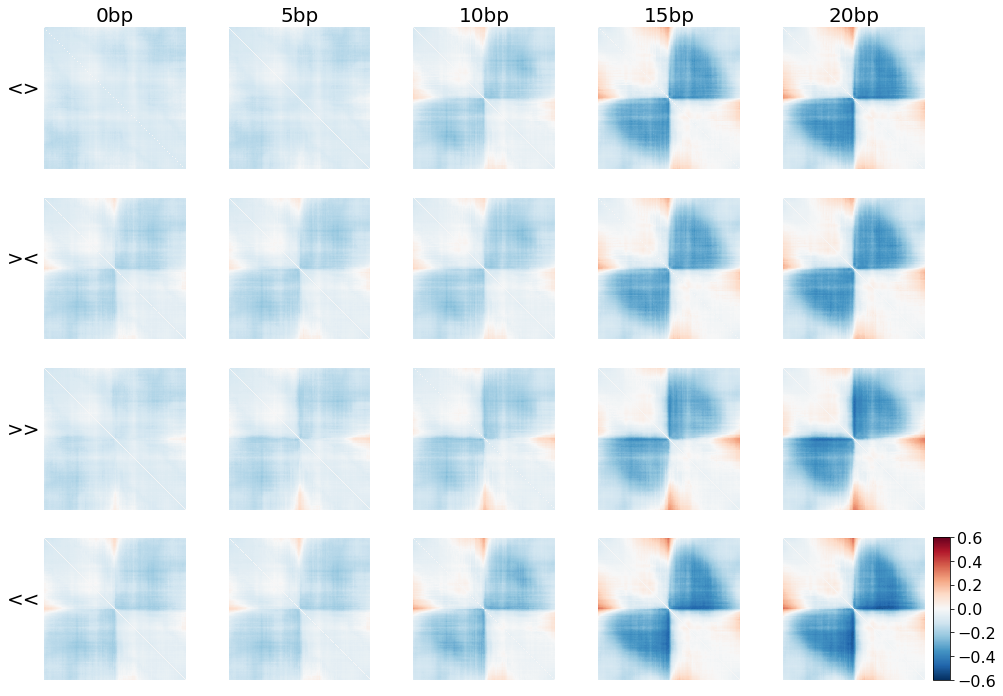

In [14]:
rows = [orientation for orientation in orientations_set]
cols = [str(flank)+"bp" for flank in flanks_set]

fig, axs = plt.subplots(len(orientations_set), len(flanks_set), figsize=(16, 12))

for flank_idx in range(len(flanks_set)):
    for orient_idx in range(len(orientations_set)):
        print(f"plotting: flank={flanks_set[flank_idx]}, orientation={orientations_set[orient_idx]}")
        
        plot_matrix = akita_utils.ut_dense(np.expand_dims(summary_matrix[orient_idx,flank_idx,:], 1), diagonal_offset)
        plot_matrix = np.squeeze(plot_matrix, axis=2)
        
        vmin = -0.6
        vmax = 0.6
        
        sns.heatmap(
            plot_matrix,
            ax=axs[orient_idx,flank_idx],
            center=0,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="RdBu_r",
            square=True,
            xticklabels=False,
            yticklabels=False,
        )
        
for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=20)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, fontsize=20, labelpad=20)

a = np.array([[-0.6,0.6]])
img = plt.imshow(a, cmap="RdBu_r")

cb_ax = fig.add_axes([0.902, 0.125, 0.015, 0.165])
cbar = fig.colorbar(img,orientation='vertical',cax=cb_ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(16)

plt.savefig("seq11.png", format="png", dpi=400)

plt.show()